# E-tivity 1 (23/01/23 - 05/02/23)

* Your Name: Eoghan O'Connor

* Your Student ID: 16110625

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv". 

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Sulis but not to gitlab. 

Marks will be deducted if task 4 is posted to gitlab in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive, max 20. Weight [5/7]

**Task 1 [0-6]**: perform and explain the steps taken in data pre-processing for this unsupervised learning model.

**Task 2 [0-4]**: correctly train model to convergence with a suitable topology and 2 encoded variables.

**Task 3 [0-4]**: select and explain choice of threshold for determining the anomalous data.

**Task 4 [0-6]**: implement a suitable VAE with correct testing and not uploaded to gitlab, in contravention of the instructions. 

## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from the Sulis site, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Monday 30/01/23)

These tasks are to be completed and uploaded to GitLab on which the other group members can comment. The forum activity will form part of the overall mark for the e-tivity.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Load the module we need
# Note that we are import the Keras backend, which is assumed to be Tensorflow
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Dropout, Flatten
from tensorflow.keras.layers import UpSampling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History

from tensorflow.keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt



from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, mse, KLDivergence
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import os

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving data.csv to data (3).csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


### **Notes**
For Processing, 1st the data is checked or displayed.
No NaN or Null values in dataset so the data is prepped for splitting.
Rescaled using MinMaxScalar to return values between 0-1.
After the data is split keeping an equal share of Anom between datasets.

In [ ]:
# Checking data
df = pd.read_csv("data.csv")
print(df.head())

   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1


In [ ]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'Anom'], dtype='object')

In [ ]:
#No null values found
df.isna().sum()

V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
Anom    0
dtype: int64

In [ ]:
# Values vary from -negative to +positive values Scalar
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Anom
count,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000
mean,46.932399,-0.063955,85.123124,0.213231,36.871784,2.160030,38.200725,48.288592,10.261930,0.071511
std,12.875159,84.674481,8.877517,37.579171,19.963113,218.324964,13.446306,20.572064,23.751024,0.257680
min,27.000000,-4821.000000,21.000000,-3939.000000,-188.000000,-26739.000000,-48.000000,-353.000000,-356.000000,0.000000
25%,37.000000,0.000000,79.000000,0.000000,30.000000,-4.000000,33.000000,35.000000,0.000000,0.000000
50%,44.000000,0.000000,83.000000,0.000000,42.000000,0.000000,39.000000,41.000000,2.000000,0.000000
75%,50.000000,0.000000,88.000000,0.000000,46.000000,5.000000,43.000000,55.000000,6.000000,0.000000
max,126.000000,5075.000000,149.000000,3830.000000,436.000000,15164.000000,105.000000,270.000000,266.000000,1.000000


In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the data
scaler.fit(df)

# Transform the data
df_scaled = scaler.transform(df)

In [ ]:
# Assign the features and labels
X = df_scaled[:, :-1]  # select all rows and all columns except the last one
y = df_scaled[:, -1]   # select all rows and the last column

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model. 

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies. 


### **Notes**
Below the Autoencoder has 3 layers.
Large dense layers worked best as small layers tended towards 0
I will try introduce early stop but looking at the losses this model will stop early after 2-3 epochs.

Dense layers were used as the data was Tabular rather than spatial (ideal for Conv)  
Relu was used throughout the model bar the last layer in the decoder. Relu reduces the dimensionality of the input data to a latent space of 2, and helps the encoder learn a compressed representation of the data by setting negative values to 0.
To reconstruct the input data a linear activation function was used as the input data had a wide range of values and a linear activation allows for this.
Maybe a sigmoid or tanh might work here too??


In [ ]:
# Define the Encoder
encoder_input = Input(shape=(X_train.shape[1],))  

x = Dense(64, activation='relu')(encoder_input)
x = Dense(32, activation='relu')(x)
latent = Dense(2,activation='relu')(x)

encoded = Model(encoder_input,latent,name='encoded')
encoded.summary()

# This is the decoder
x = Dense(64,activation='relu')(latent)
rec = Dense(9,activation='linear')(x)

decoded = Model(latent,rec,name='decoded')
decoded.summary()

decoder_output = decoded(encoded(encoder_input))
#Autoencoder Model
autoencoder = Model(encoder_input,decoder_output)
#Reconstruction loss using Mean squared error of input and decoded output
reconstruction_loss = tf.keras.losses.MeanSquaredError()(encoder_input, decoder_output)
autoencoder.add_loss(reconstruction_loss)
autoencoder.compile(optimizer='adam')
autoencoder.summary()

Model: "encoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,786
Trainable params: 2,786
Non-trainable params: 0
_________________________________________________________________
Model: "decoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]

In [ ]:
# Train the model, this can take some time
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

#Array of loss values
loss_values = history.history['loss']

Epoch 1/100
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0525 - val_loss: 0.0038
Epoch 2/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 3/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 5/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 6/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/100
1228/1228 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/100
1228/1228 [==============================] - 3s 3ms/step - l

**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

307/307 [==============================] - 1s 3ms/step


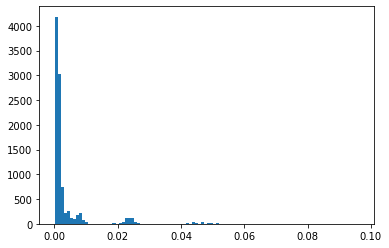

threshold is 0.009887321985351763


In [ ]:
# calculate predictions from our AutoEncoder model for the training dataset
predictions = autoencoder.predict(X_test)

# calculate the mean squared error for each sample
mse = ((X_test - predictions) ** 2).mean(axis=1)
plt.hist(mse, bins=100)
plt.show()
# sort the mse in descending order
mse_sorted = sorted(mse, reverse=True)
# calculate the index of the threshold value
threshold_index = int(len(mse_sorted) * 0.07)

# set the threshold to the value at the threshold index
threshold = mse_sorted[threshold_index]
print(f'threshold is {threshold}')
# identify the samples that have a mse greater than the threshold 
anomalies = X_test[mse > threshold]

### Post (complete by Monday 30/01/23)

Post your solution to Tasks 1-3 in notebook form. If you have not completed all the tasks then that is acceptable. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

### Respond (complete by Wednesday 01/02/23)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

Grading guidelines for the forum posts: Weight [2/7]

**Beginning [0-8]:** Respectful posts of minor value. Significant number of posts without valuable contributions and/or without well-considered questions. Posts about task 4 in contravention of intructions.

**Developing [9-12]:** At least 1 post  exceeding Beginning level with respectful suggestion or thought provoking question. Most posts contain valuable contributions or well-considered questions.

**Advancing [13-16]:** At least 2 posts: 1 equal to or exceeding Beginning level;  1 with respectful and sound contribution highlighting mistakes or alternative approaches.

**Accomplished [17-20]:** At least 3 posts: 2 equal to or exceeding Accomplished level; 1 with respectful contribution of significant value. 

### Task 4: VAE (completed by Sunday 05/02/23)

This task is a individual task and should **not** to be uploaded to GitHub. No direct support should be given via the forums, although comments about progress or results are allowed. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Sulis.

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

### Final Submission (complete by Sunday 05/02/23)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [ ]:
## Add additional code cells to implememt the tasks stated above 

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.